<a href="https://colab.research.google.com/github/shaevitz/MOL518-Intro-to-Data-Analysis/blob/main/Lecture_13/MOL518_Lecture13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# In colab run this cell first to setup the file structure!
%cd /content
!rm -rf MOL518-Intro-to-Data-Analysis

!git clone https://github.com/shaevitz/MOL518-Intro-to-Data-Analysis.git
%cd MOL518-Intro-to-Data-Analysis/Lecture_13

/content
Cloning into 'MOL518-Intro-to-Data-Analysis'...
remote: Enumerating objects: 901, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 901 (delta 123), reused 116 (delta 104), pack-reused 745 (from 1)
Receiving objects: 100% (901/901), 27.43 MiB | 27.95 MiB/s, done.
Resolving deltas: 100% (373/373), done.
/content/MOL518-Intro-to-Data-Analysis/Lecture_13



# Lecture 13: Curve Fitting Beyond Linear Regression

In this class, we will learn how to fit nonlinear curves to biological datasents and plot them in Python using Jupyter Notebooks running in Google Colab.

**Learning objectives**
- Understand when and why nonlinear models are needed (vs. linearization)
- Fit models using `scipy.optimize.curve_fit`
- Interpret parameter estimates and covariance
- Evaluate fits using residuals, $R^2$, and AIC
- Apply to common biological models: exponential growth, Michaelis–Menten kinetics, Hill equations

> Tip: Run cells in order. Each section is independent but reuses utility functions defined below.



## Setup & utilities
This cell imports libraries and defines helper functions for metrics and plotting.


In [6]:
# import necessary libraries: numpy, pandas, matplotlib, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Matplotlib defaults
plt.rcParams.update({
    "figure.figsize": (6.5, 4.2),
    "axes.grid": True,
    "grid.alpha": 0.25,
})

# Reproducibility
np.random.seed(42) # use the same random seed each time for reproducible results

# ---------- Helper functions ----------

# this function calculates the r^2 value for the curve fit
def r2_score(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot

# this function calculates the Akaike Information Criterion (AIC) for the fit
def aic(y_true, y_pred, k):
    # Akaike Information Criterion for least-squares fits.
    # k = number of free parameters
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    n = len(y_true)
    rss = np.sum((y_true - y_pred)**2)
    return 2*k + n * np.log(rss / n)

# this function plots the curve fits
def plot_fit(x, y, model, popt, xlabel="x", ylabel="y", title="Fit"):
    x = np.asarray(x)
    y = np.asarray(y)
    xs = np.linspace(np.min(x), np.max(x), 400)
    plt.scatter(x, y, s=32, alpha=0.9, label="Data")
    plt.plot(xs, model(xs, *popt), c="crimson", lw=2.0, label="Model fit")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# this function will help us plot the residuals after doing curve fitting
def plot_residuals(x, residuals, xlabel="x"):
    plt.axhline(0, color='k', lw=1, alpha=0.6)
    plt.scatter(x, residuals, s=28)
    plt.xlabel(xlabel)
    plt.ylabel("Residuals (y - ŷ)")
    plt.title("Residual plot")
    plt.show()

print("Libraries imported & utilities ready.")


Libraries imported & utilities ready.



## 1) Motivation: Why nonlinear models?
Many biological relationships are nonlinear:

- **Enzyme kinetics (Michaelis–Menten):** $v =
rac{V_\max [S]}{K_m + [S]}$
- **Cooperative binding (Hill):** $Y =
rac{[L]^n}{K_d^n + [L]^n}$
- **Growth/decay:** $y = A e^{kt}$ or logistic growth $y =
rac{K}{1 + e^{-r(t-t_0)}}$

Historically, researchers *linearized* these models (e.g., Lineweaver–Burk) but that can **distort errors** and bias estimates. Modern practice: fit the nonlinear model **directly** by least squares or likelihood.



## 2) Nonlinear regression with `scipy.optimize.curve_fit`
Key ideas:
- Define a Python function `f(x, *theta)` for your model.
- Provide **initial guesses** `p0` (crucial for convergence).
- Optional **bounds** can constrain parameters (e.g., positivity).
- `curve_fit` returns `popt` (best-fit params) and `pcov` (covariance matrix).
- Standard errors are `se = sqrt(diag(pcov))` if the model is well-specified.



### Example A — Exponential growth
Synthetic data: $y = A e^{kx} + \epsilon$.


A = 2.723 ± 0.227
k = 0.409 ± 0.009
R^2 = 0.989
AIC = 155.94


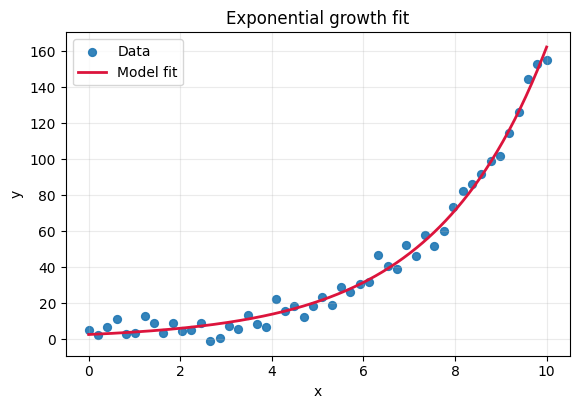

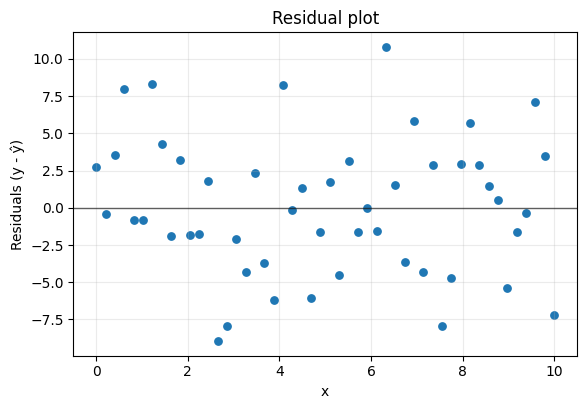

In [4]:

# ----- Generate synthetic data -----
x = np.linspace(0, 10, 50)
A_true, k_true = 3.0, 0.40
y = A_true * np.exp(k_true * x) + np.random.normal(0, 5.0, size=x.size)

# ----- Model -----
def exp_model(x, A, k):
    return A * np.exp(k * x)

# ----- Fit -----
p0 = [1.0, 0.1]  # initial guesses
popt, pcov = curve_fit(exp_model, x, y, p0=p0)
A_fit, k_fit = popt
perr = np.sqrt(np.diag(pcov))

print(f"A = {A_fit:.3f} ± {perr[0]:.3f}")
print(f"k = {k_fit:.3f} ± {perr[1]:.3f}")

# ----- Evaluate -----
yhat = exp_model(x, *popt)
print(f"R^2 = {r2_score(y, yhat):.3f}")
print(f"AIC = {aic(y, yhat, k=2):.2f}")

# ----- Plot -----
plot_fit(x, y, exp_model, popt, xlabel="x", ylabel="y", title="Exponential growth fit")
residuals = y - yhat
plot_residuals(x, residuals, xlabel="x")



## 3) Biological example — Michaelis–Menten kinetics
Model: $v = \dfrac{V_{\max} [S]}{K_m + [S]}$.

Parameters:
- $V_{\max}$: maximum reaction velocity
- $K_m$: substrate concentration at half-max velocity


In [ ]:

# ----- Generate synthetic data -----
S = np.linspace(0.05, 10.0, 30)
Vmax_true, Km_true = 5.0, 2.0
v = Vmax_true * S / (Km_true + S) + np.random.normal(0, 0.2, size=S.size)

# ----- Model -----
def mm_model(S, Vmax, Km):
    return Vmax * S / (Km + S)

# ----- Fit -----
p0 = [1.0, 1.0]
popt, pcov = curve_fit(mm_model, S, v, p0=p0, bounds=(0, np.inf))
Vmax_fit, Km_fit = popt
perr = np.sqrt(np.diag(pcov))

print(f"Vmax = {Vmax_fit:.3f} ± {perr[0]:.3f}")
print(f"Km   = {Km_fit:.3f} ± {perr[1]:.3f}")

# ----- Evaluate & plot -----
vhat = mm_model(S, *popt)
print(f"R^2 = {r2_score(v, vhat):.3f}")
print(f"AIC = {aic(v, vhat, k=2):.2f}")
plot_fit(S, v, mm_model, popt, xlabel="[S] (substrate)", ylabel="v (velocity)", title="Michaelis–Menten fit")
plot_residuals(S, v - vhat, xlabel="[S]")



## 4) Biological example — Hill binding curve
Model: $Y = \dfrac{[L]^n}{K_d^n + [L]^n}$, where $n$ is the Hill (cooperativity) coefficient.

- $K_d$: apparent dissociation constant (ligand at half-occupancy)
- $n>1$: positive cooperativity; $n=1$: noncooperative; $n<1$: negative cooperativity


In [ ]:

# ----- Generate synthetic data -----
L = np.logspace(-2, 2, 40)
Kd_true, n_true = 5.0, 2.0
Y = L**n_true / (Kd_true**n_true + L**n_true) + np.random.normal(0, 0.03, size=L.size)

# ----- Model -----

def hill(L, Kd, n):
    return L**n / (Kd**n + L**n)

# ----- Fit -----
p0 = [1.0, 1.0]
popt, pcov = curve_fit(hill, L, Y, p0=p0, bounds=(0, [np.inf, 10]))
Kd_fit, n_fit = popt
perr = np.sqrt(np.diag(pcov))

print(f"Kd = {Kd_fit:.3f} ± {perr[0]:.3f}")
print(f"n  = {n_fit:.3f} ± {perr[1]:.3f}")

# ----- Evaluate & plot -----
Yhat = hill(L, *popt)
print(f"R^2 = {r2_score(Y, Yhat):.3f}")
print(f"AIC = {aic(Y, Yhat, k=2):.2f}")
plt.semilogx()
plot_fit(L, Y, hill, popt, xlabel="[L] (ligand)", ylabel="Y (fraction bound)", title="Hill binding curve fit")
plot_residuals(L, Y - Yhat, xlabel="[L]")



## 5) Evaluating fit quality
- **Residuals:** should be structureless and roughly homoscedastic.
- **$R^2$:** fraction of variance explained (use cautiously for nonlinear models).
- **AIC:** supports model comparison; lower is better for comparable datasets.
- **Parameter uncertainty:** use `pcov` → standard errors; consider confidence intervals.

> Advanced: If measurement errors vary with $x$, pass `sigma=` and `absolute_sigma=` to `curve_fit` for weighted fits.



---
# 🧪 Exercises
Each exercise provides a dataset. Your tasks typically include:
- Define the model function
- Fit with `curve_fit` (choose sensible `p0` and bounds where appropriate)
- Plot data + fit; inspect residuals
- Report parameter estimates with interpretation

Solutions are provided in collapsible blocks. Try the problem before expanding the solution.



## Exercise 1 — Exponential decay
**Model:** $y = A e^{-k t}$  
**Data:** synthetic time-course signal with noise.

**Tasks**
1. Fit the model and estimate $A$ and $k$ (with standard errors)
2. Plot data and fitted curve
3. Report $R^2$ and AIC; comment on residuals


In [ ]:

# Dataset
np.random.seed(0)
t = np.linspace(0, 20, 40)
y = 50 * np.exp(-0.3 * t) + np.random.normal(0, 2.0, size=t.size)

# TODO: define model, fit, evaluate, and plot
# def decay_model(t, A, k):
#     return ...

# p0 = [..., ...]
# popt, pcov = curve_fit(...)
# yhat = ...
# print("A, k, R^2, AIC")
# plot_fit(...)
# plot_residuals(...)



<details>
<summary><strong>Solution (click to expand)</strong></summary>

```python
# Model
def decay_model(t, A, k):
    return A * np.exp(-k * t)

# Fit
p0 = [40.0, 0.1]
popt, pcov = curve_fit(decay_model, t, y, p0=p0, bounds=(0, np.inf))
A_fit, k_fit = popt
perr = np.sqrt(np.diag(pcov))
print(f"A = {A_fit:.3f} ± {perr[0]:.3f}")
print(f"k = {k_fit:.3f} ± {perr[1]:.3f}")

# Evaluate
yhat = decay_model(t, *popt)
print(f"R^2 = {r2_score(y, yhat):.3f}")
print(f"AIC = {aic(y, yhat, k=2):.2f}")

# Plots
plot_fit(t, y, decay_model, popt, xlabel="t (time)", ylabel="y", title="Exponential decay fit")
plot_residuals(t, y - yhat, xlabel="t")
```

</details>



## Exercise 2 — Logistic growth
**Model:** $y = \dfrac{K}{1 + e^{-r(t - t_0)}}$  
**Data:** simulated population (or signal) growth.

**Tasks**
1. Estimate $K$, $r$, and $t_0$ (with standard errors)
2. Plot data and fitted curve
3. Report $R^2$ and AIC; interpret $K$, $r$, $t_0$


In [ ]:

# Dataset
np.random.seed(2)
t = np.linspace(0, 12, 50)
K_true, r_true, t0_true = 1.0, 1.2, 6.0
y = K_true / (1 + np.exp(-r_true * (t - t0_true))) + np.random.normal(0, 0.05, size=t.size)

# TODO: define logistic model, fit, evaluate, plot
# def logistic(t, K, r, t0):
#     return ...

# p0 = [..., ..., ...]
# popt, pcov = curve_fit(...)
# yhat = ...
# print params, R^2, AIC
# plot_fit(...)
# plot_residuals(...)



<details>
<summary><strong>Solution (click to expand)</strong></summary>

```python
def logistic(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

p0 = [1.0, 1.0, np.median(t)]
popt, pcov = curve_fit(logistic, t, y, p0=p0, bounds=(0, [np.inf, np.inf, np.max(t)+10]))
K_fit, r_fit, t0_fit = popt
perr = np.sqrt(np.diag(pcov))
print(f"K  = {K_fit:.3f} ± {perr[0]:.3f}")
print(f"r  = {r_fit:.3f} ± {perr[1]:.3f}")
print(f"t0 = {t0_fit:.3f} ± {perr[2]:.3f}")

yhat = logistic(t, *popt)
print(f"R^2 = {r2_score(y, yhat):.3f}")
print(f"AIC = {aic(y, yhat, k=3):.2f}")

plot_fit(t, y, logistic, popt, xlabel="t (time)", ylabel="y", title="Logistic growth fit")
plot_residuals(t, y - yhat, xlabel="t")
```

</details>



## Exercise 3 — Michaelis–Menten kinetics
**Model:** $v = \dfrac{V_{\max} [S]}{K_m + [S]}$  
**Data:** synthetic initial velocity measurements.

**Tasks**
1. Estimate $V_{\max}$ and $K_m$ with standard errors
2. Plot $v$ vs. $[S]$ and residuals
3. Comment on how much data near low and high $[S]$ help parameter precision


In [ ]:

# Dataset
S = np.linspace(0.1, 15, 25)
v = 8 * S / (3 + S) + np.random.normal(0, 0.3, size=S.size)

# TODO: define mm_model, fit with sensible bounds, evaluate, plot
# def mm_model(S, Vmax, Km):
#     return ...

# p0 = [..., ...]
# popt, pcov = curve_fit(...)
# vhat = ...
# print params, R^2, AIC
# plot_fit(...)
# plot_residuals(...)



<details>
<summary><strong>Solution (click to expand)</strong></summary>

```python
def mm_model(S, Vmax, Km):
    return Vmax * S / (Km + S)

p0 = [5.0, 1.0]
popt, pcov = curve_fit(mm_model, S, v, p0=p0, bounds=(0, np.inf))
Vmax_fit, Km_fit = popt
perr = np.sqrt(np.diag(pcov))
print(f"Vmax = {Vmax_fit:.3f} ± {perr[0]:.3f}")
print(f"Km   = {Km_fit:.3f} ± {perr[1]:.3f}")

vhat = mm_model(S, *popt)
print(f"R^2 = {r2_score(v, vhat):.3f}")
print(f"AIC = {aic(v, vhat, k=2):.2f}")

plot_fit(S, v, mm_model, popt, xlabel="[S] (substrate)", ylabel="v (velocity)", title="Michaelis–Menten fit")
plot_residuals(S, v - vhat, xlabel="[S]")
```

</details>



## Exercise 4 — Hill coefficient & cooperativity
**Model:** $Y = \dfrac{[L]^n}{K_d^n + [L]^n}$  
**Data:** synthetic binding curve over several orders of magnitude.

**Tasks**
1. Estimate $K_d$ and $n$ (with standard errors)
2. Plot in linear-x and log-x; compare visualizations
3. Biological interpretation: does $n$ indicate cooperativity?


In [ ]:

# Dataset
L = np.logspace(-1, 2, 30)
Y = L**1.8 / (7**1.8 + L**1.8) + np.random.normal(0, 0.03, size=L.size)

# TODO: define hill(L, Kd, n), fit with bounds, evaluate, plot
# def hill(L, Kd, n):
#     return ...

# p0 = [..., ...]
# popt, pcov = curve_fit(...)
# Yhat = ...
# print params, R^2, AIC
# plt.semilogx(); plot_fit(...)
# plot_residuals(...)



<details>
<summary><strong>Solution (click to expand)</strong></summary>

```python
def hill(L, Kd, n):
    return L**n / (Kd**n + L**n)

p0 = [5.0, 1.0]
popt, pcov = curve_fit(hill, L, Y, p0=p0, bounds=(0, [np.inf, 10]))
Kd_fit, n_fit = popt
perr = np.sqrt(np.diag(pcov))
print(f"Kd = {Kd_fit:.3f} ± {perr[0]:.3f}")
print(f"n  = {n_fit:.3f} ± {perr[1]:.3f}")

Yhat = hill(L, *popt)
print(f"R^2 = {r2_score(Y, Yhat):.3f}")
print(f"AIC = {aic(Y, Yhat, k=2):.2f}")

# Plots (linear and log-x)
plot_fit(L, Y, hill, popt, xlabel="[L] (ligand)", ylabel="Y (fraction bound)", title="Hill binding fit (linear x)")
plt.semilogx()
plot_fit(L, Y, hill, popt, xlabel="[L] (ligand)", ylabel="Y (fraction bound)", title="Hill binding fit (log x)")
plot_residuals(L, Y - Yhat, xlabel="[L]")
```

</details>



## Optional: Save datasets to CSV
This cell regenerates the four exercise datasets and saves them as CSV files so you can practice loading from files.


In [ ]:

# Regenerate and save datasets
# Exercise 1
np.random.seed(0)
t = np.linspace(0, 20, 40)
y = 50 * np.exp(-0.3 * t) + np.random.normal(0, 2.0, size=t.size)
pd.DataFrame({"t": t, "y": y}).to_csv("exercise1_decay.csv", index=False)

# Exercise 2
np.random.seed(2)
t = np.linspace(0, 12, 50)
K_true, r_true, t0_true = 1.0, 1.2, 6.0
y = K_true / (1 + np.exp(-r_true * (t - t0_true))) + np.random.normal(0, 0.05, size=t.size)
pd.DataFrame({"t": t, "y": y}).to_csv("exercise2_logistic.csv", index=False)

# Exercise 3
S = np.linspace(0.1, 15, 25)
v = 8 * S / (3 + S) + np.random.normal(0, 0.3, size=S.size)
pd.DataFrame({"S": S, "v": v}).to_csv("exercise3_mm.csv", index=False)

# Exercise 4
L = np.logspace(-1, 2, 30)
Y = L**1.8 / (7**1.8 + L**1.8) + np.random.normal(0, 0.03, size=L.size)
pd.DataFrame({"L": L, "Y": Y}).to_csv("exercise4_hill.csv", index=False)

print("Saved: exercise1_decay.csv, exercise2_logistic.csv, exercise3_mm.csv, exercise4_hill.csv")
